##### Haruki Honda #####
##### 305304 #####

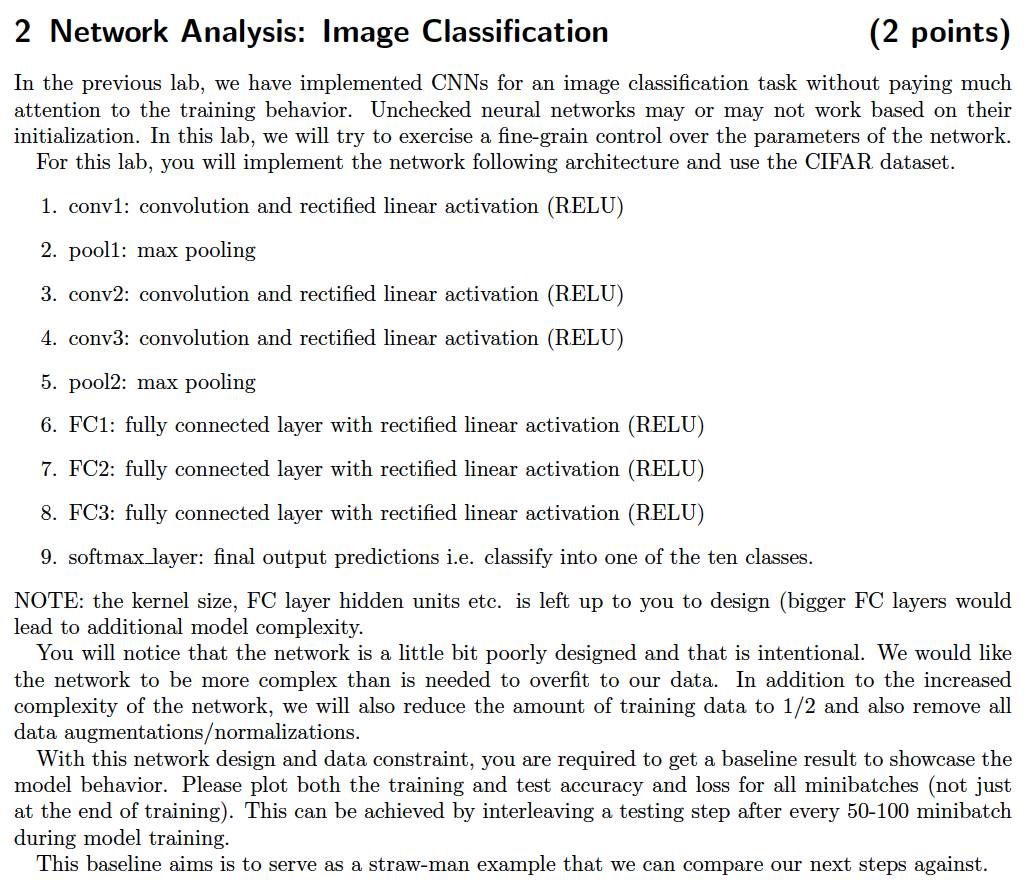

In [25]:
from IPython.display import display, Image
Image(filename = "/Users/HarukiHonda/Desktop/1.png", width=700, height=300)

##### import the required libraries #####

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms
from torch import optim

In [29]:
from tensorboardX import SummaryWriter

##### Define the architecture #####

In [65]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.fc1 = nn.Linear(64*8*8, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64,10)
    self.a = nn.Softmax(dim=1)

  def forward(self, x):
    x = F.relu(self.conv1(x)) # 16 x 32 x 32
    #print("cov1:", x.shape)
    x = F.max_pool2d(x, 2, 2) #16 x 16 x 16
    #print("pool1:", x.shape)
    x = F.relu(self.conv2(x)) #32 x 16 x 16
    #print("cov2:", x.shape) 
    x = F.relu(self.conv3(x)) #64 x 16 x 16
    #print("cov3:", x.shape)  
    x = F.max_pool2d(x, 2, 2) #64 x 8 x 8
    #print("pool2:", x.shape)
    x = torch.flatten(x, 1) # 4096
    #print("flatten:", x.shape)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.a(x)
    return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (a): Softmax(dim=1)
)


In [66]:
data_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.ToTensor()
                                     ])

training_dataset= datasets.CIFAR10(root='./data', train=True, download=True, 
                                    transform=data_train)

training_loader_crude =  torch.utils.data.DataLoader(training_dataset, 
                                                        batch_size=50, shuffle=True)

Files already downloaded and verified


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)

In [70]:
from torch.autograd import Variable
def train_crude():
    writer = SummaryWriter(logdir='logs/train_loss')
    for epoch in range(5):
        running_loss = 0.0
        running_corrects = 0.0
        for i,data in enumerate(training_loader_crude):
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            # Reset the gradient information
            optimizer.zero_grad()

            # Forward propagation
            outputs = net(inputs)

            # Calculate the loss using the cost function
            loss = criterion(outputs, labels)

            # back propagation
            loss.backward()

            # Update parameters
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

            if i % 10000  == 0:
                print('%d %d loss: %.3f' % (epoch + 1, i + 1, running_loss))
                running_loss = 0.0
                writer.add_scalar('training_loss_crude',
                        running_loss / 5,
                        epoch * len(training_loader) + i)
                writer.add_scalar('running_corrects_crude',
                        running_corrects,
                        epoch * len(training_loader) + i)
    writer.close()
    print('Finished Training')

In [ ]:
 train_crude()

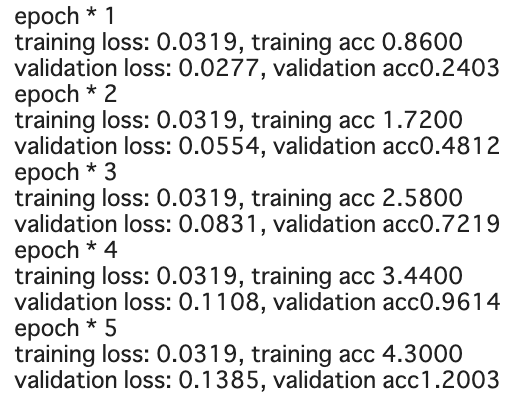

In [97]:
from IPython.display import display, Image
Image(filename = "/Users/HarukiHonda/Desktop/d_crude.png", width=300, height=150)

In [ ]:
%load_ext tensorboard.notebook
%tensorboard --logdir='logs/train_loss'

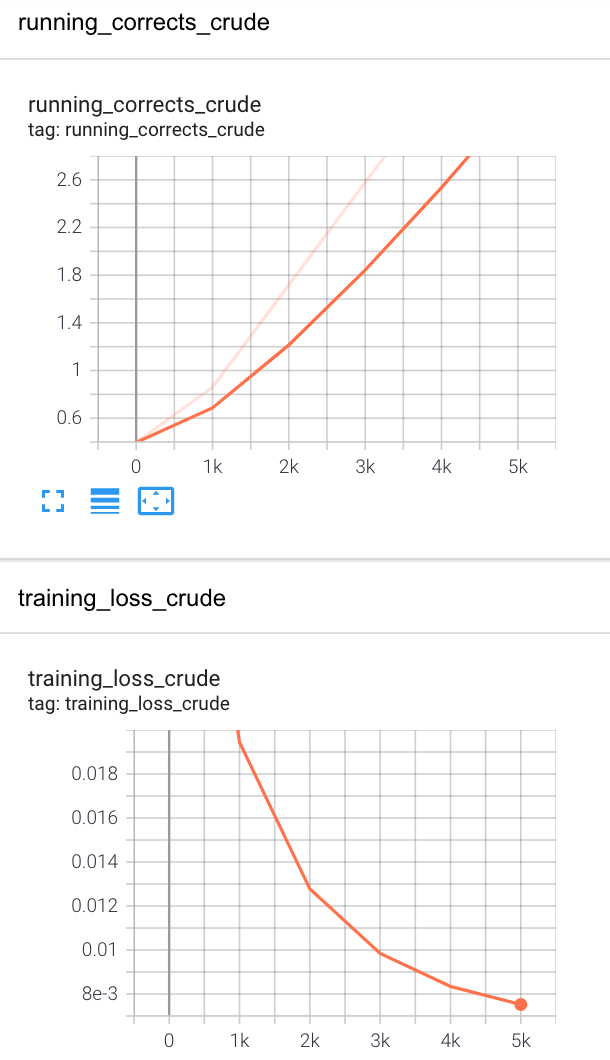

In [98]:
from IPython.display import display, Image
Image(filename = "/Users/HarukiHonda/Desktop/t_crude.png", width=400, height=300)

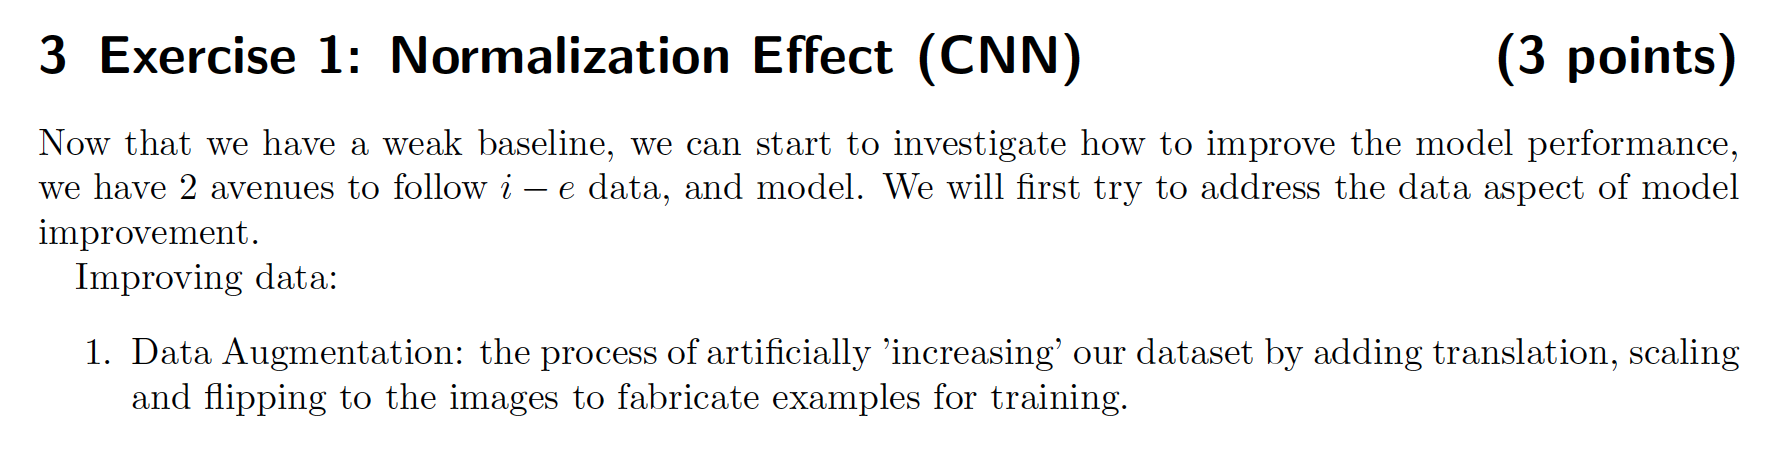

In [26]:
from IPython.display import display, Image
Image(filename = "/Users/HarukiHonda/Desktop/2.png", width=700, height=300)

#####  data aumentation #####

In [33]:
data_augmentation_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor()
                                     ])

training_dataset_augmented = datasets.CIFAR10(root='./data', train=True, download=True, 
                                    transform=data_augmentation_train)

training_loader_augmented = torch.utils.data.DataLoader(training_dataset_augmented, 
                                                        batch_size=100, shuffle=True)

Files already downloaded and verified


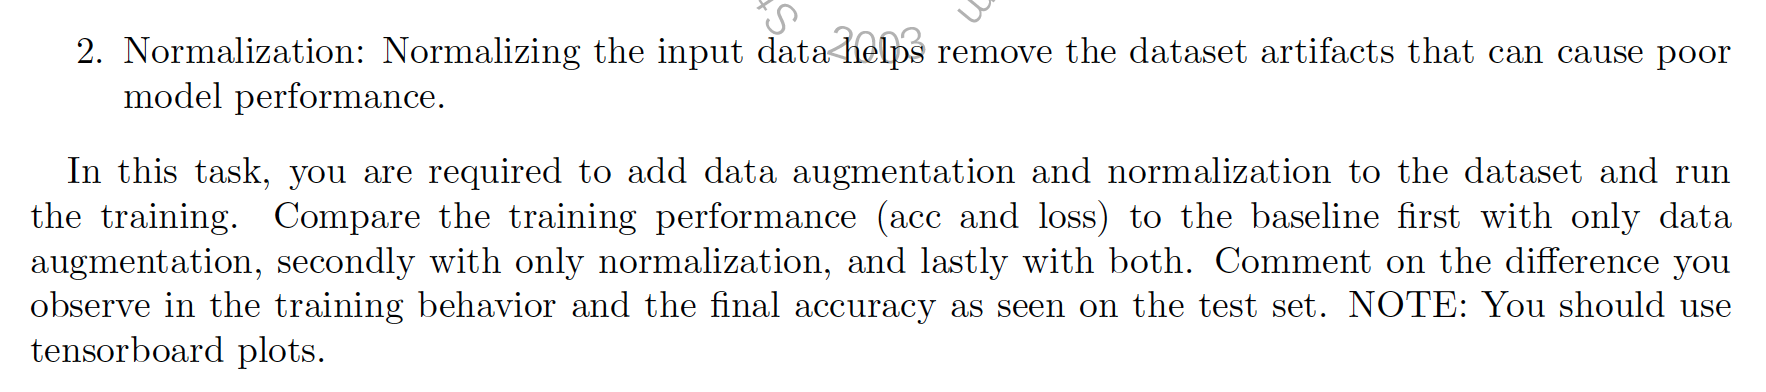

In [27]:
from IPython.display import display, Image
Image(filename = "/Users/HarukiHonda/Desktop/3.png", width=700, height=300)

##### normalization #####

In [34]:
normalization_train = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5) # RGB average
                                                     ,(0.5, 0.5, 0.5)), # RGB Standard deviation
                               ])

training_dataset_normalized = datasets.CIFAR10(root='./data', 
                                               train=True, download=True, transform=normalization_train)

training_loader_normalized = torch.utils.data.DataLoader(training_dataset_normalized, 
                                                        batch_size=100, shuffle=True)

Files already downloaded and verified


##### Both data augmentation and normalization #####

In [51]:
train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5) # RGB average
                                                     ,(0.5, 0.5, 0.5)), # RGB Standard deviation
                                     ])
training_dataset_both = datasets.CIFAR10(root='./data', train=True, download=True, transform=train)

training_loader = torch.utils.data.DataLoader(training_dataset_both, batch_size=100, shuffle=True)

Files already downloaded and verified


##### Validation ##### 

In [36]:
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
                               ])
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 80, shuffle=False)

Files already downloaded and verified


In [37]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

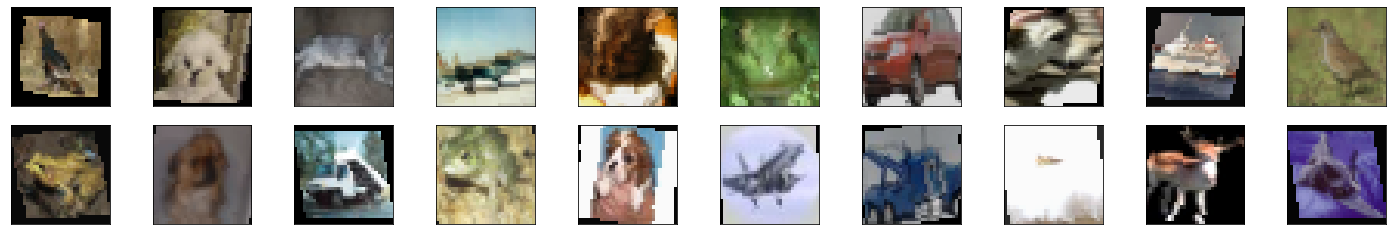

In [38]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)

In [58]:
from torch.autograd import Variable
def train():
    writer = SummaryWriter(logdir='logs/train_loss')
    running_loss_history = []
    running_corrects_history = []
    val_running_loss_history = []
    val_running_corrects_history = []
    running_loss = 0.0
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    for epoch in range(5):
        #for inputs, labels in training_loader_augmented:
        for i, data in enumerate(training_loader):
          i += 1
          inputs, labels = data
          inputs, labels = Variable(inputs), Variable(labels)
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          _, preds = torch.max(outputs, 1)
          
          running_loss += loss.item()
          running_corrects += torch.sum(preds == labels.data)
        else:
          with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
              val_outputs = net(val_inputs)
              val_loss = criterion(val_outputs, val_labels)
              
              _, val_preds = torch.max(val_outputs, 1)
          
              val_running_loss += val_loss.item()
              val_running_corrects += torch.sum(val_preds == val_labels.data)
              
      #   学習過程を記録
          epoch_loss = running_loss/len(training_loader.dataset)
          epoch_acc = running_corrects.float()/ len(training_loader.dataset)
          running_loss_history.append(epoch_loss)
          running_corrects_history.append(epoch_acc)
          val_epoch_loss = val_running_loss/len(validation_loader.dataset)
          val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
          val_running_loss_history.append(val_epoch_loss)
          val_running_corrects_history.append(val_epoch_acc)

          writer.add_scalar('training_loss_both',
                        epoch_loss /5, epoch * len(training_loader) + i)
          writer.add_scalar('running_corrects_both',
                        epoch_acc, epoch * len(training_loader) + i)
          running_loss = 0.0
          print('epoch *', (epoch+1))
          print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
          print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))
    writer.close()

##### training_loader_augmented #####

In [84]:
from torch.autograd import Variable
def train_augmented():
    writer = SummaryWriter(logdir='logs/train_loss')
    running_loss_history = []
    running_corrects_history = []
    val_running_loss_history = []
    val_running_corrects_history = []
    running_loss = 0.0
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    for epoch in range(5):
        #for inputs, labels in training_loader_augmented:
        for i, data in enumerate(training_loader_augmented):
          i += 1
          inputs, labels = data
          inputs, labels = Variable(inputs), Variable(labels)
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          _, preds = torch.max(outputs, 1)
          
          running_loss += loss.item()
          running_corrects += torch.sum(preds == labels.data)
        else:
          with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
              val_outputs = net(val_inputs)
              val_loss = criterion(val_outputs, val_labels)
              
              _, val_preds = torch.max(val_outputs, 1)
          
              val_running_loss += val_loss.item()
              val_running_corrects += torch.sum(val_preds == val_labels.data)
              
      #   学習過程を記録
          epoch_loss = running_loss/len(training_loader_augmented.dataset)
          epoch_acc = running_corrects.float()/ len(training_loader_augmented.dataset)
          running_loss_history.append(epoch_loss)
          running_corrects_history.append(epoch_acc)
          val_epoch_loss = val_running_loss/len(validation_loader.dataset)
          val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
          val_running_loss_history.append(val_epoch_loss)
          val_running_corrects_history.append(val_epoch_acc)

          writer.add_scalar('training_loss_augment',
                        epoch_loss /5, epoch * len(training_loader_augmented) + i)
          writer.add_scalar('running_corrects_augment',
                        epoch_acc, epoch * len(training_loader_augmented) + i)
          running_loss = 0.0
          print('epoch *', (epoch+1))
          print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
          print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))
    writer.close()

##### training_loader_normalized #####

In [86]:
from torch.autograd import Variable
def train_normalized():
    writer = SummaryWriter(logdir='logs/train_loss')
    running_loss_history = []
    running_corrects_history = []
    val_running_loss_history = []
    val_running_corrects_history = []
    running_loss = 0.0
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    for epoch in range(5):
        #for inputs, labels in training_loader_crude:
        for i, data in enumerate(training_loader_normalized):
          i += 1
          inputs, labels = data
          inputs, labels = Variable(inputs), Variable(labels)
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          _, preds = torch.max(outputs, 1)
          
          running_loss += loss.item()
          running_corrects += torch.sum(preds == labels.data)
        else:
          with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
              val_outputs = net(val_inputs)
              val_loss = criterion(val_outputs, val_labels)
              
              _, val_preds = torch.max(val_outputs, 1)
          
              val_running_loss += val_loss.item()
              val_running_corrects += torch.sum(val_preds == val_labels.data)
              
      #   学習過程を記録
          epoch_loss = running_loss/len(training_loader_normalized.dataset)
          epoch_acc = running_corrects.float()/ len(training_loader_normalized.dataset)
          running_loss_history.append(epoch_loss)
          running_corrects_history.append(epoch_acc)
          val_epoch_loss = val_running_loss/len(validation_loader.dataset)
          val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
          val_running_loss_history.append(val_epoch_loss)
          val_running_corrects_history.append(val_epoch_acc)

          writer.add_scalar('training_loss_normal',
                        epoch_loss /5, epoch * len(training_loader_normalized) + i)
          writer.add_scalar('running_corrects_normal',
                        epoch_acc, epoch * len(training_loader_normalized) + i)
          running_loss = 0.0
          print('epoch *', (epoch+1))
          print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
          print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))
    writer.close()

In [59]:
train()

1 1 loss: 2.140
2 1 loss: 2.045
3 1 loss: 2.074
4 1 loss: 2.118
5 1 loss: 2.072
6 1 loss: 2.039
7 1 loss: 1.994
8 1 loss: 1.954
9 1 loss: 2.045
10 1 loss: 2.005
Finished Training


In [85]:
train_augmented()

1 1 loss: 2.303
2 1 loss: 2.302
3 1 loss: 2.302
4 1 loss: 2.303
5 1 loss: 2.302
Finished Training


In [ ]:
train_normalized()

In [ ]:
%load_ext tensorboard.notebook
%tensorboard --logdir='logs/train_loss'

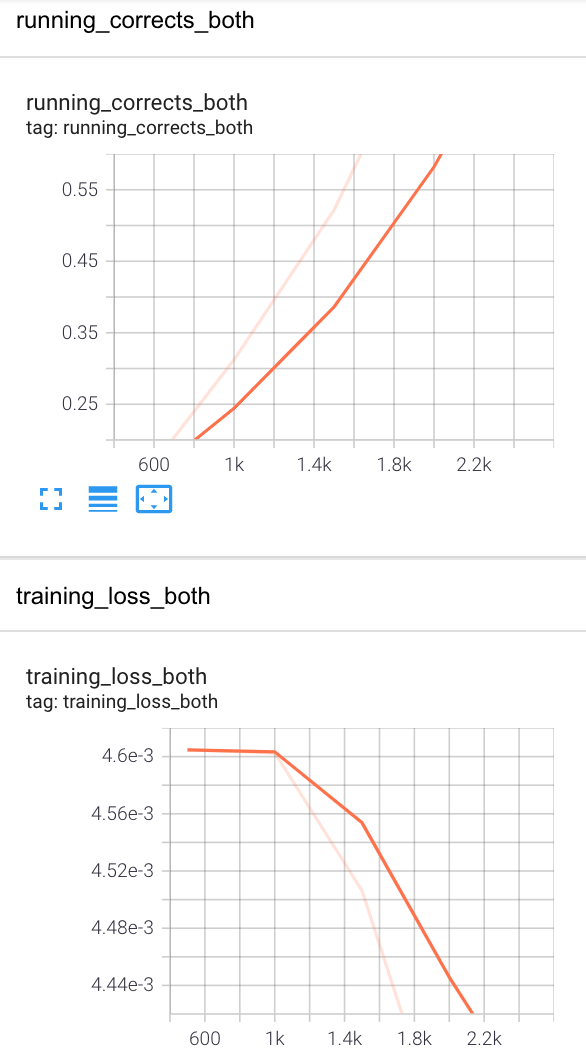

In [104]:
from IPython.display import display, Image
Image(filename = "/Users/HarukiHonda/Desktop/train.png", width=400, height=300)

In [ ]:
from IPython.display import display, Image
Image(filename = "/Users/HarukiHonda/Desktop/correct.png", width=400, height=300)

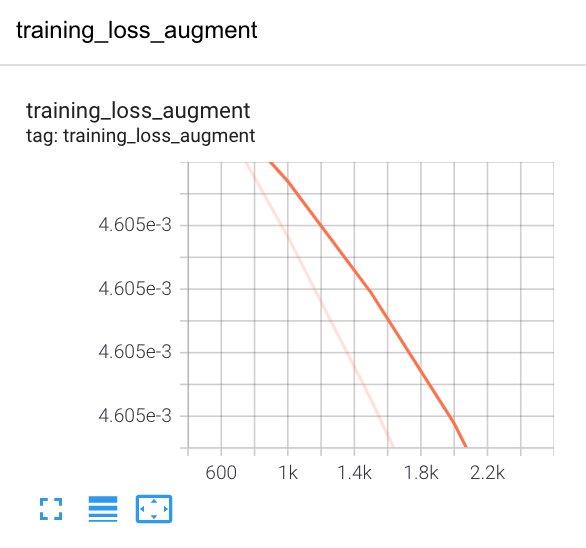

In [102]:
from IPython.display import display, Image
Image(filename = "/Users/HarukiHonda/Desktop/aug_r.png", width=400, height=300)

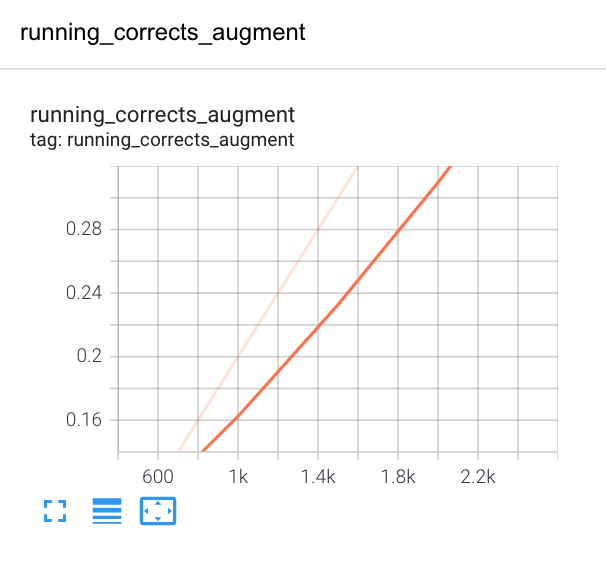

In [103]:
from IPython.display import display, Image
Image(filename = "/Users/HarukiHonda/Desktop/aug.png", width=400, height=300)

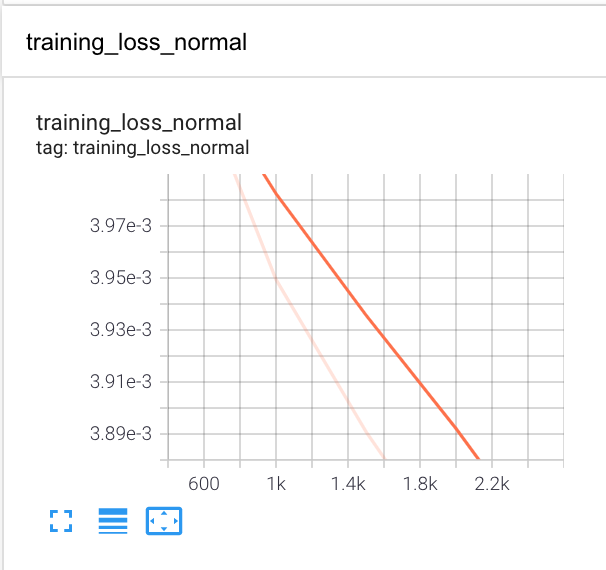

In [99]:
from IPython.display import display, Image
Image(filename = "/Users/HarukiHonda/Desktop/normal.png", width=400, height=300)

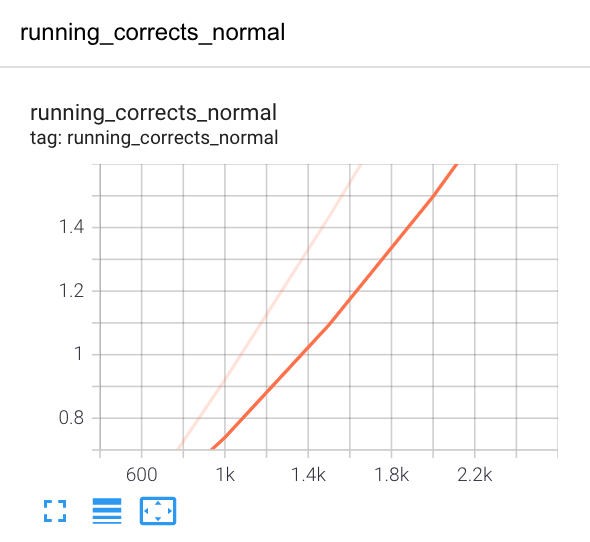

In [100]:
from IPython.display import display, Image
Image(filename = "/Users/HarukiHonda/Desktop/normal_r.png", width=400, height=300)

##### I found that  the loss with the both normalized and augmented dataset is more rapidly decreasing than the single normalized data set and augmented dataset. And the accuracy with the both normalized and augmented dataset is more higher than these datasets. #####

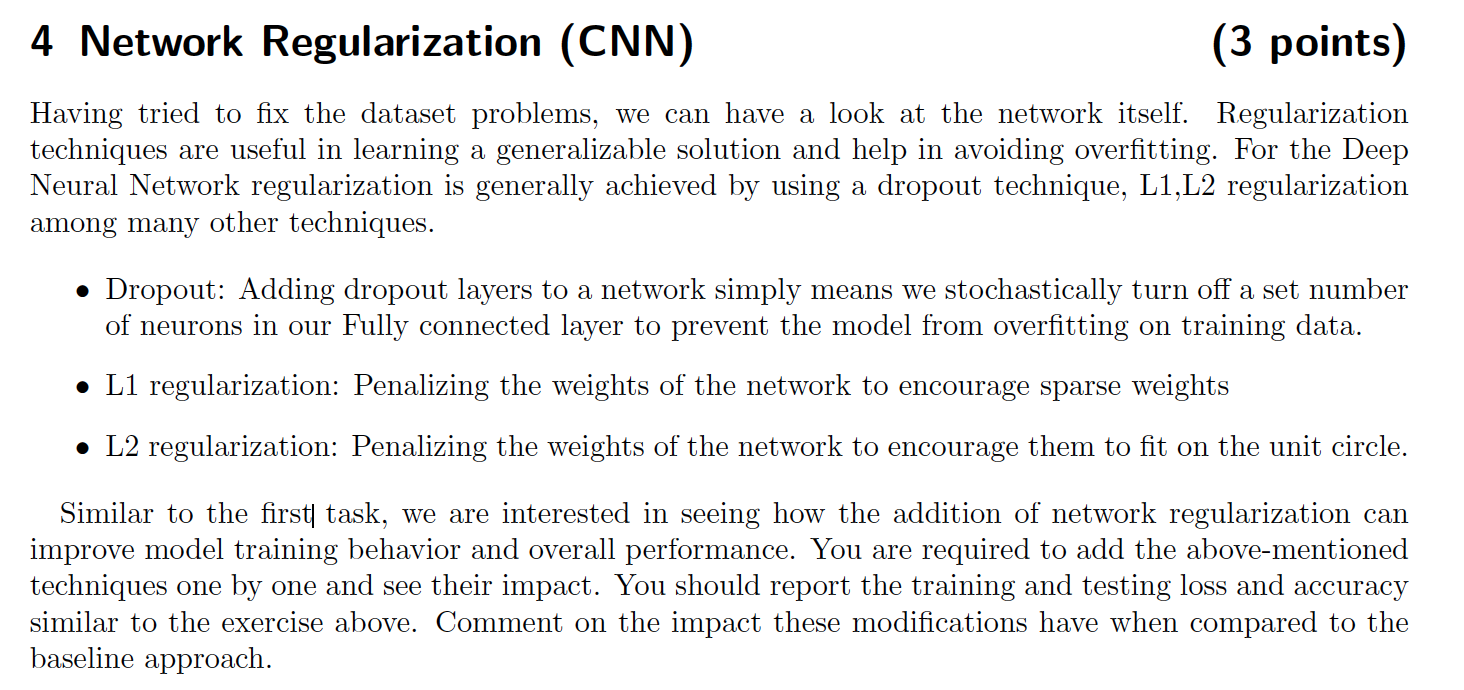

In [62]:
from IPython.display import display, Image
Image(filename = "/Users/HarukiHonda/Desktop/4.png", width=700, height=300)

##### Adding dropout layer #####

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.fc1 = nn.Linear(64*8*8, 512)
    self.fc2 = nn.Linear(512, 64)
    self.dropout1 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(64,10)
    self.a = nn.Softmax(dim=1)

  def forward(self, x):
    x = F.relu(self.conv1(x)) # 16 x 32 x 32
    #print("cov1:", x.shape)
    x = F.max_pool2d(x, 2, 2) #16 x 16 x 16
    #print("pool1:", x.shape)
    x = F.relu(self.conv2(x)) #32 x 16 x 16
    #print("cov2:", x.shape) 
    x = F.relu(self.conv3(x)) #64 x 16 x 16
    #print("cov3:", x.shape)  
    x = F.max_pool2d(x, 2, 2) #64 x 8 x 8
    #print("pool2:", x.shape)
    x = torch.flatten(x, 1) # 4096
    #print("flatten:", x.shape)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.dropout1(x)
    x = self.a(x)
    return x

net = Net()
print(net)

##### Drop Out #####

In [ ]:
from torch.autograd import Variable
def train_dropout():
    writer = SummaryWriter(logdir='logs/train_loss')
    running_loss_history = []
    running_corrects_history = []
    val_running_loss_history = []
    val_running_corrects_history = []
    running_loss = 0.0
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    for epoch in range(5):
        #for inputs, labels in training_loader_augmented:
        for i, data in enumerate(training_loader):
          i += 1
          inputs, labels = data
          inputs, labels = Variable(inputs), Variable(labels)
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          _, preds = torch.max(outputs, 1)
          
          running_loss += loss.item()
          running_corrects += torch.sum(preds == labels.data)
        else:
          with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
              val_outputs = net(val_inputs)
              val_loss = criterion(val_outputs, val_labels)
              
              _, val_preds = torch.max(val_outputs, 1)
          
              val_running_loss += val_loss.item()
              val_running_corrects += torch.sum(val_preds == val_labels.data)
              
      #   学習過程を記録
          epoch_loss = running_loss/len(training_loader.dataset)
          epoch_acc = running_corrects.float()/ len(training_loader.dataset)
          running_loss_history.append(epoch_loss)
          running_corrects_history.append(epoch_acc)
          val_epoch_loss = val_running_loss/len(validation_loader.dataset)
          val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
          val_running_loss_history.append(val_epoch_loss)
          val_running_corrects_history.append(val_epoch_acc)

          writer.add_scalar('training_loss_both',
                        epoch_loss /5, epoch * len(training_loader) + i)
          writer.add_scalar('running_corrects_both',
                        epoch_acc, epoch * len(training_loader) + i)
          running_loss = 0.0
          print('epoch *', (epoch+1))
          print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
          print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))
    writer.close()

In [ ]:
train_dropout():

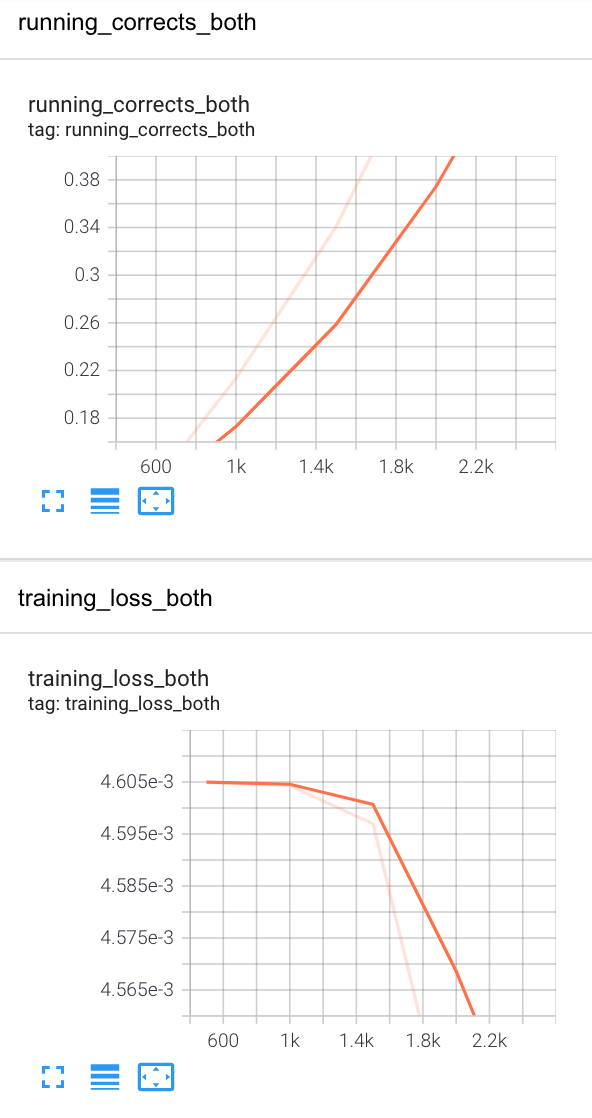

In [108]:
from IPython.display import display, Image
Image(filename = "/Users/HarukiHonda/Desktop/dropout.png", width=400, height=300)

##### L1 and L2 #####

In [ ]:
from torch.autograd import Variable
def train_L1_L2():
    writer = SummaryWriter(logdir='logs/train_loss')
    running_loss_history = []
    running_corrects_history = []
    val_running_loss_history = []
    val_running_corrects_history = []
    running_loss = 0.0
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    for epoch in range(5):
        #for inputs, labels in training_loader_augmented:
        for i, data in enumerate(training_loader):
          i += 1
          inputs, labels = data
          inputs, labels = Variable(inputs), Variable(labels)
          outputs = net(inputs)
          # Calculate the loss using the cost function
          loss = criterion(outputs, labels)

          l1_regularization, l2_regularization = torch.tensor([0], dtype=torch.float32), torch.tensor([0],
                          dtype=torch.float32) # Define L1 and L2 regularization loss
                # Note that the for loop here should be commented out when weight_decay is defined above
          for param in net.parameters():
                        l1_regularization += torch.norm(param, 1) # L1 regularization
                        l2_regularization += torch.norm(param, 2) # L2 regularization

          loss_l1 = loss + l1_regularization #L1 regularization
          #loss_l2 = loss + l2_regularization # L2 regularization
          
          # back propagation
          loss_l1.backward()

          # Update parameters
          optimizer.step()
          _, preds = torch.max(outputs, 1)
          running_loss +=  loss_l1.item()
          running_corrects += torch.sum(preds == labels.data)

        else:
          with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
              val_outputs = net(val_inputs)
              val_loss = criterion(val_outputs, val_labels)
              
              _, val_preds = torch.max(val_outputs, 1)
          
              val_running_loss += val_loss.item()
              val_running_corrects += torch.sum(val_preds == val_labels.data)
              
      #   学習過程を記録
          epoch_loss = running_loss/len(training_loader.dataset)
          epoch_acc = running_corrects.float()/ len(training_loader.dataset)
          running_loss_history.append(epoch_loss)
          running_corrects_history.append(epoch_acc)
          val_epoch_loss = val_running_loss/len(validation_loader.dataset)
          val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
          val_running_loss_history.append(val_epoch_loss)
          val_running_corrects_history.append(val_epoch_acc)

          writer.add_scalar('training_loss_both',
                        epoch_loss /5, epoch * len(training_loader) + i)
          writer.add_scalar('running_corrects_both',
                        epoch_acc, epoch * len(training_loader) + i)
          running_loss = 0.0
          print('epoch *', (epoch+1))
          print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
          print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))
    writer.close()

In [ ]:
train_L1_L2():

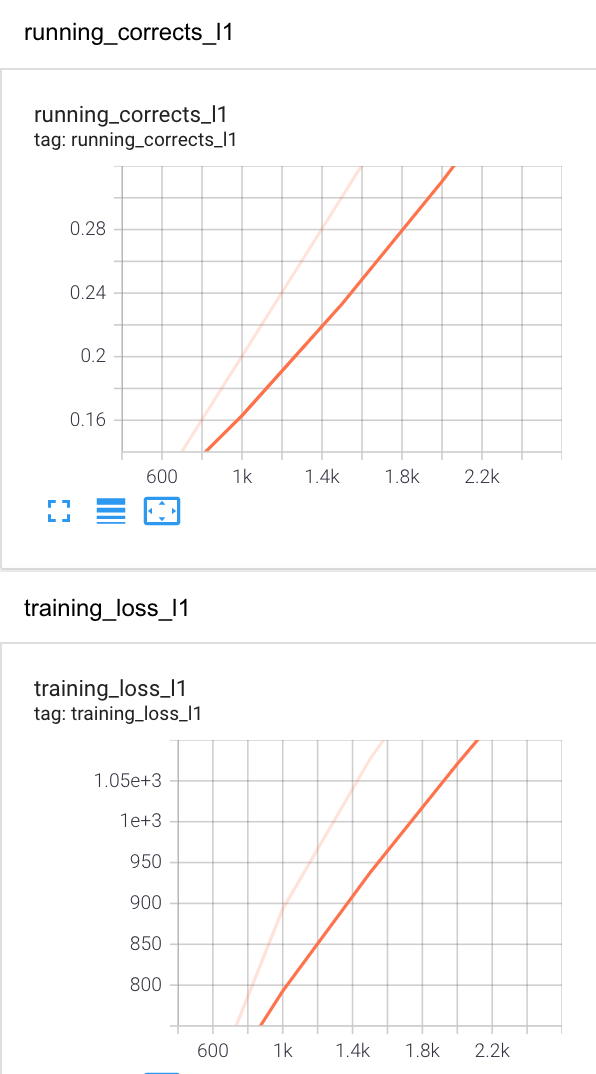

In [105]:
from IPython.display import display, Image
Image(filename = "/Users/HarukiHonda/Desktop/l1_t.png", width=400, height=300)

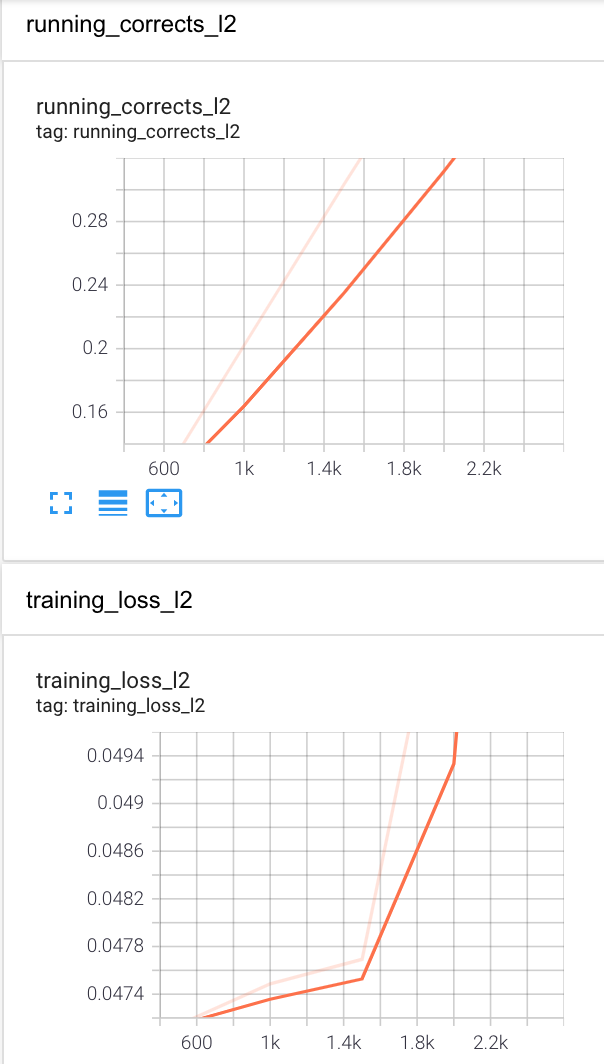

In [110]:
from IPython.display import display, Image
Image(filename = "/Users/HarukiHonda/Desktop/l2_t.png", width=400, height=300)

##### Comparing to the baseline approach, the dropout approach makes faster to reach the same accuracy level. And the dropout approach decrease the loss while the l1 and l2 increase the loss. 

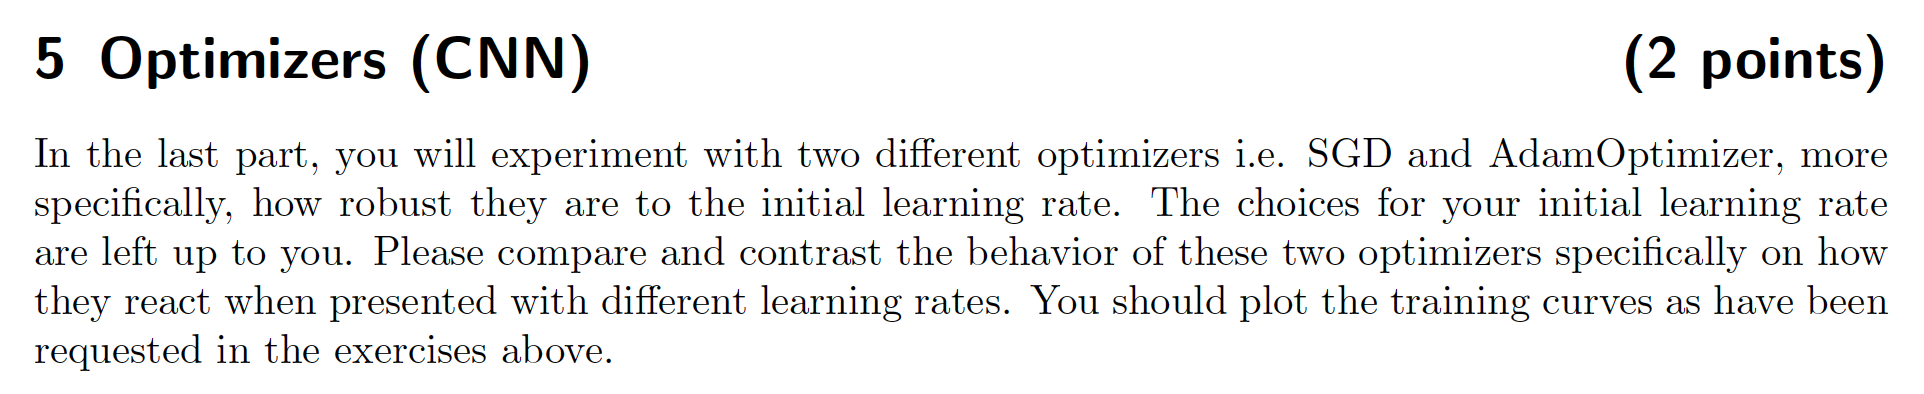

In [64]:
from IPython.display import display, Image
Image(filename = "/Users/HarukiHonda/Desktop/5.png", width=700, height=300)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [ ]:
from torch.autograd import Variable
def train():
    writer = SummaryWriter(logdir='logs/train_loss')
    for epoch in range(5):
        running_loss = 0.0
        running_corrects = 0.0
        for i,data in enumerate(training_loader):
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            # Reset the gradient information
            optimizer.zero_grad()
            # Forward propagation
            outputs = net(inputs)
            # Calculate the loss using the cost function
            loss = criterion(outputs, labels)
            # back propagation
            loss.backward()

            # Update parameters
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

            if i % 10000  == 0:
                print('%d %d loss: %.3f' % (epoch + 1, i + 1, running_loss))
                running_loss = 0.0
                writer.add_scalar('training_loss',
                        running_loss / 5,
                        epoch * len(training_loader) + i)
    writer.close()
    print('Finished Training')

In [ ]:
train()

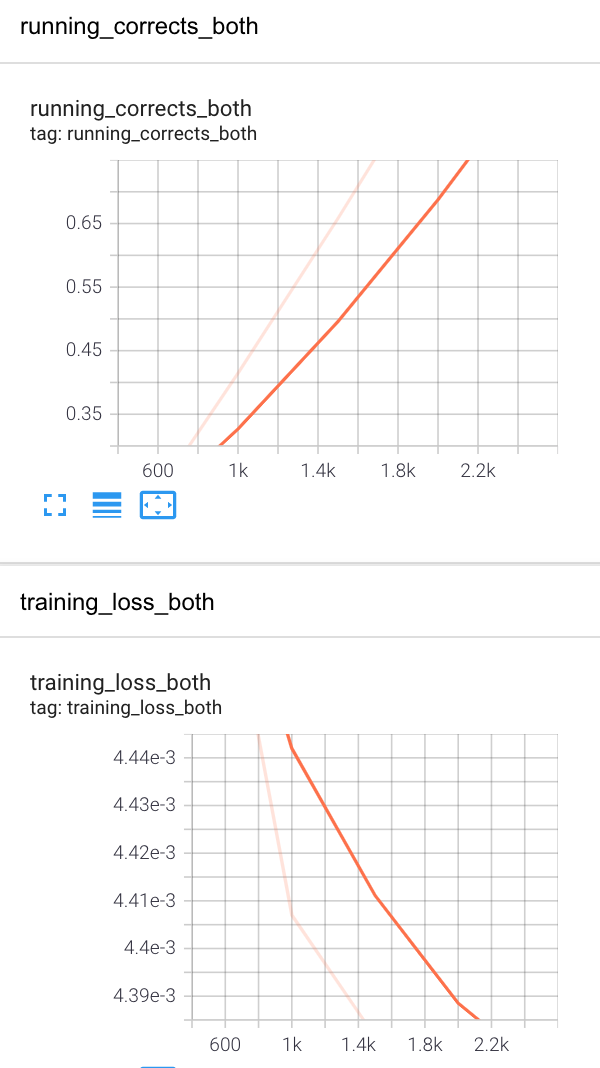

In [107]:
from IPython.display import display, Image
Image(filename = "/Users/HarukiHonda/Desktop/Adam_t.png", width=400, height=300)

##### Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html #####